# Notes

We shouldn't use pre-trained model to `sign-language-mnist` because the image size is not sufficient enough to be as input of the selected pre-trained model (MobileNet V2).

## References

Q. Xiang, et.al., (2019) *Fruit Image Classification Based on MobileNetV2 with Transfer Learning Technique*, https://doi.org/10.1145/3331453.3361658

In [77]:
import os
import sys
import random
import shutil
import time
import string


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

from keras_preprocessing import image as keras_prep_image

In [3]:
tf.__version__

'2.2.0'

In [5]:
# Make numpy values easier to read
np.set_printoptions(precision=3, suppress=True)

# Load data

In [20]:
train_file_path = "dataset/sign-language-mnist/sign_mnist_train.csv"
test_file_path = "dataset/sign-language-mnist/sign_mnist_test.csv"

In [170]:
def read_dataset(filepath):
    with open(filepath, 'r') as f:
        rows = f.readline()
        rows = f.readlines()
        
        label = []
        data = []
        N_rows = len(rows)
        for i, line in enumerate(rows):
            sys.stdout.write('\rProcessing: {:.2f}%'.format((i+1)*100/float(N_rows)))
            sys.stdout.flush()
            line = line.split(',')
            hot_rod = np.zeros(26)
            hot_rod[int(line[0])] = 1.
            label.append(hot_rod)
            data.append(np.array([float(pixel.strip('\n')) for pixel in line[1:]]).reshape(28, 28))
            
            #if i == 5:
            #    break
    print("")    
    return np.array(data), np.array(label, dtype=int)

In [171]:
raw_train_images, train_label = read_dataset(train_file_path)
raw_test_images, test_label = read_dataset(test_file_path)

Processing: 100.00%
Processing: 100.00%


In [172]:
print(raw_train_images.shape)
print(train_label.shape)

print(raw_test_images.shape)
print(test_label.shape)

N_train = train_images.shape[0]
N_test = test_images.shape[0]

(27455, 28, 28)
(27455, 26)
(7172, 28, 28)
(7172, 26)


In [210]:
train_images = raw_train_images.reshape(N_train, 28, 28, 1)/255.
test_images = raw_test_images.reshape(N_test, 28, 28, 1)/255.


Show several images from the training set.

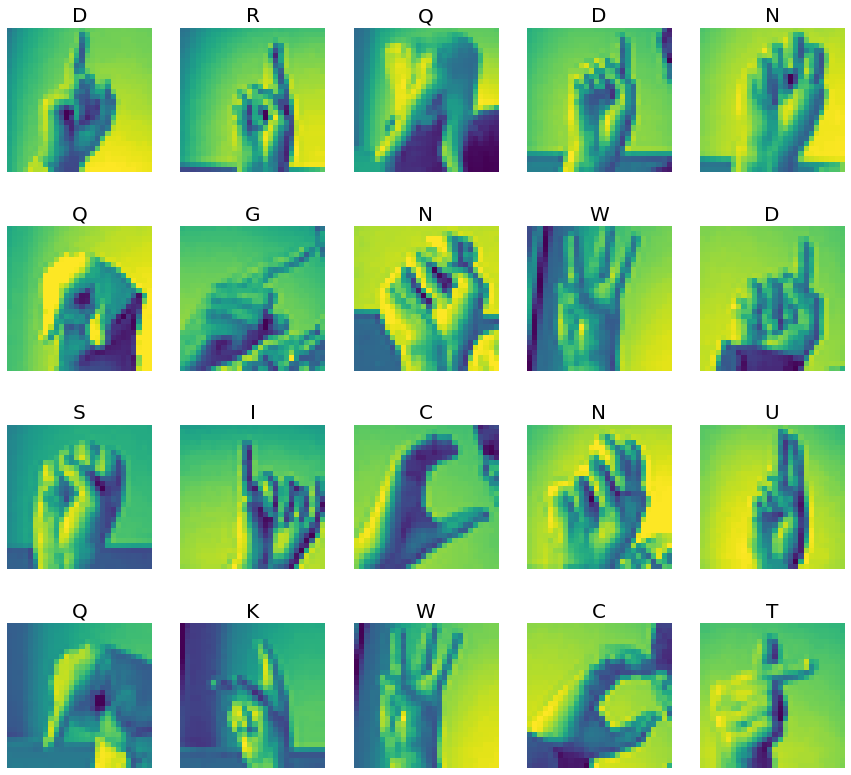

In [211]:
num_images = 20   # Numbers of images plot
num_row = 4       # Axes row setting
letter_map = string.ascii_uppercase[:26]

num_col = int(round(num_images / float(num_row)))

fig, ax = plt.subplots(figsize=(15, 14), 
                       nrows=num_row, 
                       ncols=num_col)

for i, (img_train, img_label) in enumerate(zip(train_images[:num_images], 
                                               train_label[:num_images])):
    img_train = img_train[:, :, 0]
    title = letter_map[img_label.argmax()]
    
    ax[i % num_row, i % num_col].imshow(img_train) 
    ax[i % num_row, i % num_col].set_title(title, fontsize=20)
    ax[i % num_row, i % num_col].axis('off')


In [212]:
# some callbacks for time measurement and early stopping
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.perf_counter()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.perf_counter() - self.epoch_time_start)
        
class LossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get("accuracy") > 0.996:
            print("\nReached 99.6% accuracy so cancelling training!")
            self.model.stop_training = True

time_callback = TimeHistory()
loss_callback = LossCallback()

Inspect an image

In [213]:
image_batch = train_images
label_batch = [train_label[0]]

image_batch = tf.constant(image_batch)
label_batch = tf.constant(label_batch)

image_batch.shape

TensorShape([27455, 28, 28, 1])

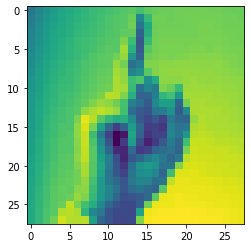

In [214]:
image_batch_ndarray = tf.make_ndarray(tf.make_tensor_proto(image_batch[0]))
plt.imshow(image_batch_ndarray[:, :, 0]);

In [215]:
label_batch

<tf.Tensor: shape=(1, 26), dtype=int32, numpy=
array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]], dtype=int32)>

# Layers construction

## Define some layers

In [216]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])



## Compile the model

In [217]:
base_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [218]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10816)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2769152   
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 26)                6682      
Total params: 2,842,266
Trainable params: 2,842,266
Non-trainable params: 0
____________________________________________

In [219]:
len(model.trainable_variables)

8

## Train the model

In [222]:
initial_epochs = 100
steps_per_epoch = N_train // 32   # the number of samples in our dataset divided by the batch size
validation_steps = N_test // 16    # Total number of steps (batches of samples) to draw before stopping 
                                    # when performing validation at the end of every epoch

loss0, accuracy0 = model.evaluate(test_images, test_label, steps=validation_steps)

422/448 [===========================>..] - 1s 3ms/step - loss: 3.2597 - accuracy: 0.0541


In [208]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.26
initial accuracy: 0.06


In [209]:
history = model.fit(train_images, train_label,
                    epochs=initial_epochs,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    callbacks=[time_callback, loss_callback])

Epoch 1/100
857/857 [==============================] - 20s 23ms/step - loss: 3.2824 - accuracy: 0.0397
Epoch 2/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2822 - accuracy: 0.0399
Epoch 3/100
857/857 [==============================] - 20s 23ms/step - loss: 3.2827 - accuracy: 0.0394
Epoch 4/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2823 - accuracy: 0.0398
Epoch 5/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2828 - accuracy: 0.0394
Epoch 6/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2828 - accuracy: 0.0393
Epoch 7/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2824 - accuracy: 0.0397
Epoch 8/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2818 - accuracy: 0.0403
Epoch 9/100
857/857 [==============================] - 20s 24ms/step - loss: 3.2830 - accuracy: 0.0391
Epoch 10/100
857/857 [==============================] - 21s 25ms/step - l

857/857 [==============================] - 19s 22ms/step - loss: 3.2819 - accuracy: 0.0402
Epoch 80/100
857/857 [==============================] - 19s 22ms/step - loss: 3.2826 - accuracy: 0.0396
Epoch 81/100
857/857 [==============================] - 19s 22ms/step - loss: 3.2820 - accuracy: 0.0401
Epoch 82/100
857/857 [==============================] - 18s 22ms/step - loss: 3.2826 - accuracy: 0.0396
Epoch 83/100
857/857 [==============================] - 18s 22ms/step - loss: 3.2821 - accuracy: 0.0400
Epoch 84/100
857/857 [==============================] - 19s 22ms/step - loss: 3.2830 - accuracy: 0.0391
Epoch 85/100
857/857 [==============================] - 19s 22ms/step - loss: 3.2829 - accuracy: 0.0393
Epoch 86/100
857/857 [==============================] - 18s 21ms/step - loss: 3.2829 - accuracy: 0.0392
Epoch 87/100
857/857 [==============================] - 19s 22ms/step - loss: 3.2819 - accuracy: 0.0402
Epoch 88/100
857/857 [==============================] - 18s 21ms/step - loss:

In [ ]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

## Learning curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
num_computed_epochs = len(history.epoch)
print(f"number of computed epochs before the fitting stopped: {num_computed_epochs}")

In [ ]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


for fn in test_path_all:
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    classes_name = np.array(alphabet)
    ##print(classes_name[np.array([int(round(p)) for p in classes[0]]) == 1])
    #print(fn, 'is', classes_name[np.array([int(round(p)) for p in classes[0]]) == 1][0])

    #print(classes_name[classes[0].argmin()])
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = classes_name[classes[0].argmin()]
    print(f"{fn} is {predicted_label} ({fn_label == predicted_label})")

# Fine tuning

## Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

## Compile the model

In [ ]:
# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
#               metrics=['accuracy'])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
               optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
               metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

## Continue training the model

In [ ]:
fine_tune_epochs = num_computed_epochs
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         steps_per_epoch=steps_per_epoch,
                         initial_epoch=history.epoch[-1],
                         verbose=1,
                         validation_steps=validation_steps,
                         validation_data=validation_generator,
                         callbacks=[time_callback, loss_callback])

In [ ]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1, initial_epochs-1], 
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.show()

In [ ]:
alphabet = [letter.upper() for letter in "abcdefghiklmnopqrstuvwxy"]

#fn = "./hand-sign-real-data/D-lugo.jpg"

base_test_dir = "DataSet Signos splitted/test"

test_path_all = [os.path.join(base_test_dir, letter_path, image_path) 
                 for letter_path in os.listdir(base_test_dir)
                    for image_path in os.listdir(os.path.join(base_test_dir, letter_path))]
#print(test_path_all)


for fn in test_path_all:
    #break
    img = keras_prep_image.load_img(fn, target_size=input_shape[:2],
                                    color_mode='rgb')
    x = keras_prep_image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    classes_name = np.array(alphabet)
    ##print(classes_name[np.array([int(round(p)) for p in classes[0]]) == 1])
    #print(fn, 'is', classes_name[np.array([int(round(p)) for p in classes[0]]) == 1][0])

    #print(classes_name[classes[0].argmin()])
    fn_label = os.path.split(os.path.split(fn)[0])[-1]
    predicted_label = classes_name[classes[0].argmin()]
    print(f"{fn} is {predicted_label} ({fn_label == predicted_label})")